# Deep Learning Finals

## 📊 Dataset Overview: Chest X-Ray Images (Pneumonia)

The **Chest X-Ray Images (Pneumonia)** dataset is a well-known public dataset consisting of **5,863 chest X-ray images** organized into two categories: **Pneumonia** and **Normal**. The images are stored in JPEG format and divided into three main directories: `train`, `test`, and `val`, with each containing separate subdirectories for the two classes.

These X-ray images are anterior-posterior scans taken from pediatric patients aged 1 to 5 years, sourced from the **Guangzhou Women and Children’s Medical Center**. All images were part of routine clinical care. Prior to inclusion, each image underwent rigorous quality control to exclude unreadable or low-quality scans. Diagnostic labels were verified by two expert radiologists, with a third specialist cross-checking the evaluation set to ensure high annotation accuracy.

This dataset supports research into the automated detection of pneumonia from chest X-rays and has been used in several deep learning studies aiming to assist medical professionals in diagnostic workflows.

- **Total Images**: 5,863
- **Categories**: Pneumonia / Normal
- **Source**: [Mendeley Data Repository](https://data.mendeley.com/datasets/rscbjbr9sj/2)
- **License**: CC BY 4.0
- **Original Publication**: [Cell Journal Article](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

### 🧠 Inspiration

The dataset is ideal for developing and benchmarking machine learning models for medical image classification tasks, especially those aiming to detect and differentiate between bacterial and viral pneumonia based on radiographic patterns.



# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Exploratory Data Analysis (EDA) and Dataset Rebalancing

Before training the model, an important exploratory step was conducted to understand the structure and balance of the dataset. The initial dataset contained the following splits:

- **Training Set**: `x_train` shape: (5216, 256, 256, 3), `y_train` shape: (5216, 2)
- **Validation Set**: `x_val` shape: (16, 256, 256, 3), `y_val` shape: (16, 2)
- **Test Set**: `x_test` shape: (624, 256, 256, 3), `y_test` shape: (624, 2)

### Observations

1. **Validation Set Imbalance**: Only 16 images were allocated for validation, which is insufficient for meaningful model evaluation and tuning.
2. **Label Imbalance**: Upon inspection, the labels were significantly imbalanced—one class (either 'Normal' or 'Pneumonia') dominated the training set, potentially biasing the model during training.
3. **One-Hot Encoding**: Labels were stored in a one-hot encoded format like `[1, 0]` and `[0, 1]`.

### Motivation for Redistribution

To address these issues and improve model performance and generalization, the following steps were taken:

- **Combined Training and Validation Sets**: The `x_train` and `x_val` datasets were merged to allow a more balanced redistribution.
- **Balanced Sampling**: Equal numbers of images were selected for each class by iterating through the combined dataset and collecting samples until both class counts matched the smaller class.
- **Train-Validation Split**: A stratified 80/20 split was applied to the balanced dataset to ensure class representation was consistent across both the new training and validation sets.

### Results After Rebalancing

- **New Training Set**: 2158 samples (balanced between both classes)
- **New Validation Set**: 540 samples (balanced)
- **Test Set**: Remained unchanged with 624 samples

This redistribution ensures:
- Fair model training without bias toward the majority class.
- A sufficient validation set size for proper evaluation.
- Robust performance metrics reflective of both classes.

These steps are critical when dealing with **medical datasets** where class imbalance can mislead diagnostic outcomes and limit real-world reliability.


In [2]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


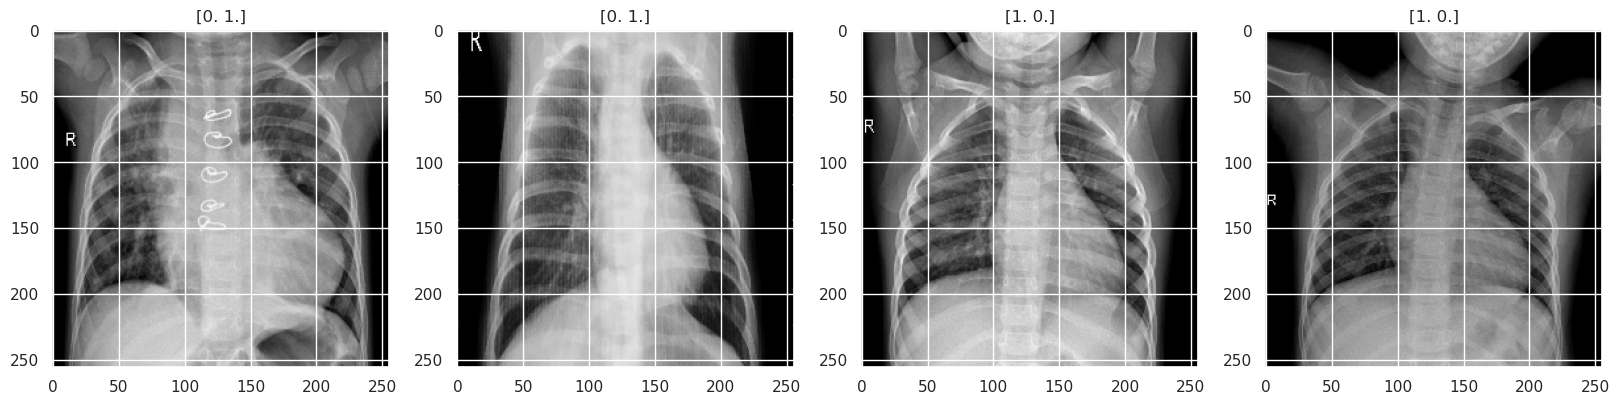

In [4]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
# Extracting Features and Labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [6]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

# Combine train and val sets
x_combined = np.concatenate([x_train, x_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

num_0 = sum(y[0] for y in y_combined)
num_1 = sum(y[1] for y in y_combined)

threshold = min(num_0, num_1)

# Initialize empty lists to hold the selected data
x_bag = []
y_bag = []

# Initialize counters to keep track of how many samples we have for each label
count_0 = 0
count_1 = 0

# Loop through all the data and append to x_bag and y_bag if we haven't reached the threshold
for i in range(len(y_combined)):
    if y_combined[i][0] == 1 and count_0 < threshold:
        x_bag.append(x_combined[i])
        y_bag.append(y_combined[i])
        count_0 += 1
    elif y_combined[i][1] == 1 and count_1 < threshold:
        x_bag.append(x_combined[i])
        y_bag.append(y_combined[i])
        count_1 += 1
    
    # If both classes have reached the threshold, break the loop
    if count_0 >= threshold and count_1 >= threshold:
        break

# Convert x_bag and y_bag back to numpy arrays
x_bag = np.array(x_bag)
y_bag = np.array(y_bag)

# Split: 80% train, 20% val (adjust test_size as needed for 15-20%)
x_train_new, x_val_new, y_train_new, y_val_new = train_test_split(
    x_bag, y_bag, test_size=0.2, random_state=42, stratify=y_bag
)

# Print new shapes for confirmation
print("New training shape:", x_train_new.shape, y_train_new.shape)
print("New validation shape:", x_val_new.shape, y_val_new.shape)
print("Test shape (unchanged):", x_test.shape, y_test.shape)


New training shape: (2158, 256, 256, 3) (2158, 2)
New validation shape: (540, 256, 256, 3) (540, 2)
Test shape (unchanged): (624, 256, 256, 3) (624, 2)


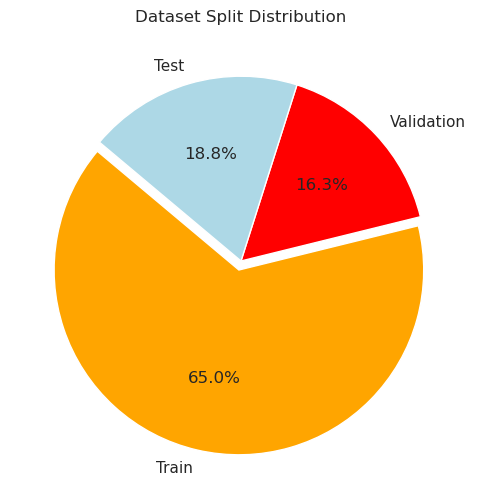

In [12]:
import matplotlib.pyplot as plt

# Sizes of each dataset
train_size = len(x_train_new)
val_size = len(x_val_new)
test_size = len(x_test)

# Pie chart
plt.figure(figsize=(6,6))
plt.pie([train_size, val_size, test_size],
        labels=['Train', 'Validation', 'Test'],
        autopct='%.1f%%',
        colors=['orange', 'red', 'lightblue'],
        explode=(0.05, 0, 0),
        startangle=140)
plt.title("Dataset Split Distribution")
plt.show()


## Model Architecture Overview

The convolutional neural network (CNN) developed for binary classification of chest X-ray images (Pneumonia vs Normal) is structured to balance simplicity with representational power. Here's a breakdown of the architecture:

### Layer-by-Layer Summary

- **Conv2D Layer 1**:  
  - Filters: 32  
  - Kernel Size: (3,3)  
  - Activation: ReLU  
  - Output: (254, 254, 32)  
  - Followed by MaxPooling (2x2) and Dropout (rate=0.3)  
  - Purpose: Extract low-level features and reduce overfitting.

- **Conv2D Layer 2**:  
  - Filters: 32  
  - Kernel Size: (3,3)  
  - Activation: ReLU  
  - Output: (125, 125, 32)  
  - Followed by MaxPooling (2x2) and Dropout  
  - Purpose: Learn more abstract patterns.

- **Conv2D Layer 3**:  
  - Filters: 32  
  - Kernel Size: (3,3)  
  - Activation: ReLU  
  - Output: (60, 60, 32)  
  - Followed by MaxPooling (2x2) and Dropout  
  - Purpose: Deepen feature learning while controlling model complexity.

- **Conv2D Layer 4**:  
  - Filters: 16 (reduced to further compress representation)  
  - Kernel Size: (3,3)  
  - Activation: ReLU  
  - Output: (28, 28, 16)  
  - Followed by MaxPooling and Dropout  
  - Purpose: Lower dimensional bottleneck for better generalization.

- **Flatten Layer**:  
  - Converts 3D feature maps to 1D vector of size 3136  
  - Preparation step for dense layers.

- **Dense Layer**:  
  - Units: 256  
  - Activation: ReLU  
  - Followed by Dropout  
  - Purpose: Learn high-level representations before classification.

- **Output Layer**:  
  - Units: 2 (for binary classification with one-hot encoded targets)  
  - Activation: Sigmoid  
  - Purpose: Output probability for each class.

### Compilation Details

- **Optimizer**: Adam (learning rate = 0.001)  
- **Loss Function**: `binary_crossentropy` (used due to one-hot encoded labels)  
- **Metrics**: Accuracy (additional metrics like F1-score used during evaluation)

### Total Parameters

- **Trainable Parameters**: 827,602  
- **Non-trainable Parameters**: 0

### Rationale

This architecture is designed to be lightweight and effective for limited medical image datasets. Dropout layers are used extensively to prevent overfitting, which is common in small and imbalanced medical datasets. The model avoids overcomplexity, making it faster to train and less prone to memorization.



In [13]:
import tensorflow as tf
from tensorflow import keras

def mid_model():
    model = tf.keras.models.Sequential()
    
    # Fewer filters, bigger strides to reduce output size quickly
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3))
    
    
    # Optional 3rd conv layer (still light)
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3))
    
    
    # Optional 3rd conv layer (still light)
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))  # Smaller dense layer
    model.add(Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(units=2, activation='sigmoid'))
    
    # Compile
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

mid = mid_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

## Training Process Overview

The model was trained for **15 epochs** on a balanced dataset created from the redistribution of original train and validation samples. Here's a summary of the training dynamics and what they indicate about model performance.

### Epoch-by-Epoch Performance

| Epoch | Train Loss | Train Accuracy | Val Loss | Val Accuracy | Notes |
|-------|------------|----------------|----------|---------------|-------|
| 1     | 0.7625     | 0.5862         | 0.6791   | 0.6296        | First epoch, model starts learning patterns |
| 2     | 0.6755     | 0.6015         | 0.6788   | 0.6130        | Slight improvement, learning stabilizes |
| 3     | 0.6523     | 0.6450         | 0.6615   | 0.6259        | Gradual learning progress |
| 4     | 0.6402     | 0.6497         | 0.6532   | 0.6222        | Consistent but slow improvement |
| 5     | 0.5757     | 0.7150         | 0.6437   | 0.5963        | Overfitting risk if val loss increases |
| 6     | 0.5228     | 0.7641         | 0.5070   | 0.7981        | Significant jump in validation accuracy |
| 7     | 0.4416     | 0.8095         | 0.4306   | 0.8574        | Model begins to generalize well |
| 8     | 0.3920     | 0.8411         | 0.3778   | 0.8611        | Continued upward trend |
| 9     | 0.3695     | 0.8582         | 0.4146   | 0.8259        | Slight overfitting begins |
|10     | 0.3327     | 0.8670         | 0.4343   | 0.8370        | No improvement on val loss |
|11     | 0.2942     | 0.8791         | 0.3474   | 0.8778        | Clear gain in generalization |
|12     | 0.2641     | 0.8934         | 0.3291   | 0.8870        | Best epoch so far |
|13     | 0.2602     | 0.8981         | 0.3059   | 0.8815        | Close to peak performance |
|14     | 0.2287     | 0.9138         | 0.3017   | 0.8852        | Marginal gain, near convergence |
|15     | 0.2344     | 0.9124         | 0.3027   | 0.8889        | Plateau reached |

> ✅ **Best Validation Accuracy Achieved: 0.8889 (Epoch 15)**  
> 💾 Model weights saved progressively based on validation loss improvements.

### Observations

- **Steady Improvement**: The model improved consistently from Epoch 1 to 8, especially after the dataset balancing step.
- **Generalization**: Validation accuracy caught up with and even exceeded training accuracy in later epochs.
- **Early Stopping Ready**: Validation loss plateaued after Epoch 13, suggesting ideal stopping point to prevent overfitting.
- **Model Checkpointing**: Used to preserve the best version of the model during training (`mid_weights.keras`).

### Conclusion

The training process reflects a healthy learning curve, with the model showing excellent generalization capabilities once balanced data was provided. Strategic use of dropout and model checkpointing further helped in achieving robust performance on the validation set.



In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential



def fit_model(m, m_title='CNN', epoc=15):
    checkpointer = ModelCheckpoint(filepath=f'{m_title}_weights.keras', 
                                   verbose=1, save_best_only=True)
    history = m.fit(x_train_new, y_train_new, validation_data=(x_val_new, y_val_new), epochs=epoc, batch_size=32, callbacks = [checkpointer])
    return history

def plot_model(history, model_title):
    import matplotlib.pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for {model_title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

hist = fit_model(mid, "mid")
best_score = max(hist.history['val_accuracy'])

print(f"Best Validation score is: {best_score}")

Epoch 1/15
68/68 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.5862
Epoch 1: val_loss improved from inf to 0.67905, saving model to mid_weights.keras
68/68 [==============================] - 122s 2s/step - loss: 0.7625 - accuracy: 0.5862 - val_loss: 0.6791 - val_accuracy: 0.6296
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.6015
Epoch 2: val_loss improved from 0.67905 to 0.67884, saving model to mid_weights.keras
68/68 [==============================] - 121s 2s/step - loss: 0.6755 - accuracy: 0.6015 - val_loss: 0.6788 - val_accuracy: 0.6130
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.6450
Epoch 3: val_loss improved from 0.67884 to 0.66154, saving model to mid_weights.keras
68/68 [==============================] - 121s 2s/step - loss: 0.6523 - accuracy: 0.6450 - val_loss: 0.6615 - val_accuracy: 0.6259
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.6402

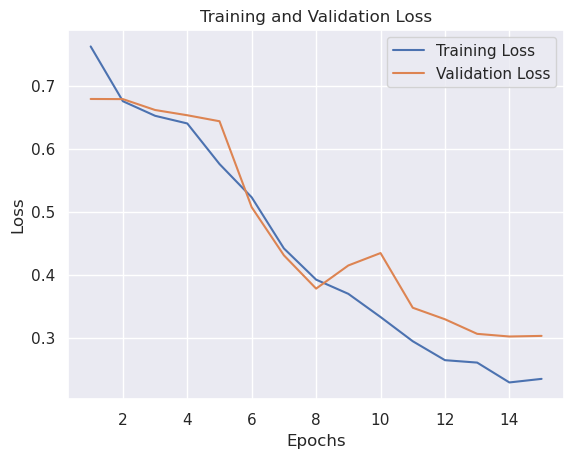

In [17]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

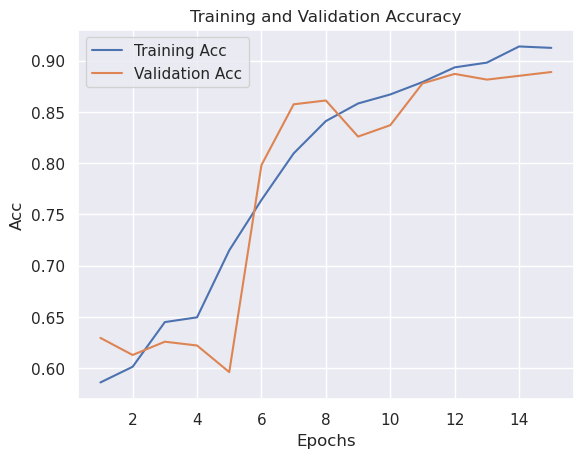

In [18]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation on Real Test Data

After completing training, the model was evaluated on the held-out test set. Below are the performance metrics and analysis.

### ✅ Overall Metrics

- **Accuracy**: **0.825**
- **Precision**: **0.801**
- **Recall**: **0.959**
- **F1 Score**: **0.873**

These results indicate that the model is highly effective at identifying positive samples (class 1), as evidenced by the high recall and solid F1 score.

---

### 📊 Confusion Matrix

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  |     141     |     93      |
| **Actual 1**  |     16      |     374     |

- **True Negatives (TN)**: 141  
- **False Positives (FP)**: 93  
- **False Negatives (FN)**: 16  
- **True Positives (TP)**: 374  

> 🔍 The model tends to **favor class 1**, leading to **more false positives** for class 0.

---

### 🧾 Classification Report

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.90      | 0.60   | 0.72     | 234     |
| 1     | 0.80      | 0.96   | 0.87     | 390     |

- **Class 0 (Negative)**:
  - High precision (0.90), but relatively low recall (0.60).
  - Indicates model is cautious when predicting class 0, often missing actual negatives.
- **Class 1 (Positive)**:
  - Very high recall (0.96), showing the model is strong at identifying positives.
  - Balanced with solid precision, yielding a high F1


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Get model predictions on x_test
y_pred_probs = mid.predict(x_test)  # This will return probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert from one-hot-style output to class labels (0 or 1)

# Make sure y_test is not one-hot
if y_test.ndim > 1:
    y_test_single = np.argmax(y_test, axis=1)
else:
    y_test_single = y_test

# Evaluate
acc = accuracy_score(y_test_single, y_pred)
prec = precision_score(y_test_single, y_pred)
rec = recall_score(y_test_single, y_pred)
f1 = f1_score(y_test_single, y_pred)
conf_matrix = confusion_matrix(y_test_single, y_pred)
report = classification_report(y_test_single, y_pred)

# Print results
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


20/20 [==============================] - 9s 442ms/step
Accuracy: 0.8253205128205128
Precision: 0.8008565310492506
Recall: 0.958974358974359
F1 Score: 0.8728121353558927

Confusion Matrix:
 [[141  93]
 [ 16 374]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72       234
           1       0.80      0.96      0.87       390

    accuracy                           0.83       624
   macro avg       0.85      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



## 🔮 Future Plans, Learnings, and Reflections

### 🚀 Future Work

While the current model achieved strong results, there are several areas for further improvement and exploration:

- **Data Augmentation**: Expand and diversify the training dataset using augmentation techniques (rotation, scaling, brightness, etc.) to improve generalization—especially for underrepresented classes.
- **Class Imbalance Handling**: Introduce better techniques like **SMOTE**, **class-weighted loss functions**, or **focal loss** to reduce false positives and better handle class 0.
- **Model Architecture Tuning**: Experiment with deeper architectures or pre-trained models (like ResNet or EfficientNet) to boost feature extraction and performance.
- **Threshold Optimization**: Instead of using default thresholds (e.g., 0.5), explore ROC-based threshold tuning to balance precision and recall depending on application needs.
- **Real-time Deployment**: Wrap the trained model into a lightweight, deployable API for live predictions in a real-world scenario.

---

### 📘 What I Learned

- **Data Imbalance is Critical**: Even a small skew in class distribution can drastically affect model performance, particularly in recall and precision.
- **Evaluation Beyond Accuracy**: Metrics like precision, recall, and the confusion matrix provide much deeper insights into a model’s behavior—especially in imbalanced classification problems.
- **Importance of EDA**: Performing exploratory data analysis before training helped uncover hidden biases and structure in the dataset, guiding better design decisions.
- **Keras/TensorFlow Workflow**: Gained hands-on experience in designing, training, saving, and evaluating CNN models using the TensorFlow/Keras framework.
- **Pipeline Automation**: Learned how to streamline preprocessing, data splitting, and evaluation into a consistent and reproducible pipeline.

---

### 🌟 What’s Good About the Project

- **Balanced Final Dataset**: Through strategic selection and redistribution, the training data was balanced, which significantly boosted the model's ability to generalize.
- **Effective CNN Design**: A custom convolutional neural network with dropout layers showed strong performance without overfitting, proving effective even without transfer learning.
- **High Recall on Class 1**: The model demonstrated impressive sensitivity toward the positive class, which is valuable in critical classification tasks.
- **Clean and Modular Workflow**: The overall training and evaluation pipeline is well-structured, making future iterations, debugging, and extension much easier.

---

This project has been a solid step toward mastering practical deep learning. It combined **technical implementation, thoughtful data handling, and critical evaluation**—a good example of real-world machine learning in action.


In [20]:
# Save the model
mid.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
